# Agenda

#### 1- Variational Quantum Eigensolver (VQE)
#### 2- Generative Pre-training Transformer- Quantum Eigensolver (GPT-QE)

### 1- Variational quantum eignsolver:

![img](./VQE.png)

### 1. VQA using ```cudaq.observe()``` & classical optimizer.
- Using cudaq built-in optimizer

In [1]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_param = [0.0, 0.0]

cost_values = []

def cost(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(vqe_circuit, hamiltonian, parameters).expectation()
    cost_values.append(expectation_value)
    return expectation_value

initial_cost_value = cost(initial_param)
print('Initial cost value: ', initial_cost_value)
print('Initial parameters: ', initial_param)

# Define a CUDA-Q optimizer.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = initial_param

result = optimizer.optimize(dimensions=2, function=cost)

print('Final cost value: ', result[0])
print('Optimized parameters: ', result[1])


Initial cost value:  1.0
Initial parameters:  [0.0, 0.0]
Final cost value:  -0.9999999999999981
Optimized parameters:  [3.141592653589793, 0.0]


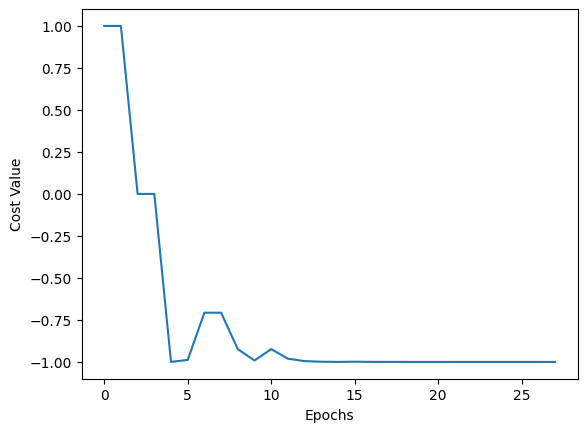

In [2]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.show()

- using third-party optimizer: ex. scipy optimizer

In [3]:
import cudaq
from cudaq import spin
import scipy

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit_scipy(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)

# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_parameters = [0.0, 0.0]

def cost_scipy(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(vqe_circuit_scipy, hamiltonian, parameters).expectation()
    return expectation_value

initial_cost_value = cost_scipy(initial_parameters)
print('Initial cost value: ', initial_cost_value)
print('Initial parameters: ', initial_parameters)


result = scipy.optimize.minimize(cost_scipy,initial_parameters,method='COBYLA')

print('Final cost value: ', result.fun)
print('Optimized parameters: ', result.x)

Initial cost value:  1.0
Initial parameters:  [0.0, 0.0]
Final cost value:  -0.9999999970938906
Optimized parameters:  [3.14159466e+00 1.07798234e-04]


- VQE wrapper: combine ```cudaq.observe()``` and the optimizer

In [4]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_param = [0.0, 0.0]

optimizer = cudaq.optimizers.COBYLA()
optimizer.max_iterations = 30
optimizer.initial_parameters=initial_param

opt_value, opt_theta = cudaq.vqe(kernel=vqe_circuit, 
                         spin_operator=hamiltonian,
                         optimizer=optimizer,
                         parameter_count=len(initial_param))

print(f"\nminimized <H> = {round(opt_value,16)}")
print(f"optimal theta = {opt_theta}")


minimized <H> = -0.9999999999999981
optimal theta = [3.141592653589793, 0.0]


### Example: Max-Cut with QAOA

- #### Max-Cut

Each of these cuts below partitions the graph into two disjoint sets. The cut on the left is not optimal, and the cut on the right is the max cut. The cut on the left divides the graph into disjoint sets {1,2}  and {0,3,4}, and that cut contains 3 edges. To more easily visualize the cut, we have colored the vertices in one set of the partition green and the vertices in the other set of the partition gray. The cut depicted in the diagram on the right divides the graph vertices into two disjoint sets {0,2}, colored gray, and {1,3,4}, colored green.

![img](./maxcut.png)

For the graph on the right, the number of edges in the cut (in this case there are  edges) is maximal, and this value is referred to as the max cut value.

The max cut solutions are 01011, 10100, 01010, 10101 

- #### QAOA algorithm:
$$
H= \frac{1}{2} \sum_{u,v} \left(Z_u Z_v - I_u I_v\right)
$$

![img](./QAOA.png)

In [5]:
import cudaq
from cudaq import spin
import numpy as np

cudaq.set_target('nvidia')


nodes: list[int] = [0, 1, 2, 3, 4]
edges = [[0, 1], [1, 2], [2, 3], [3, 0], [2, 4], [3, 4]]
edges_src: list[int] = [edges[i][0] for i in range(len(edges))]
edges_tgt: list[int] = [edges[i][1] for i in range(len(edges))]

qubit_count: int = len(nodes)
layer_count: int = 2
parameter_count: int = 2 * layer_count

@cudaq.kernel
def qaoaProblem(qubit_0: cudaq.qubit, qubit_1: cudaq.qubit, alpha: float):
    x.ctrl(qubit_0, qubit_1)
    rz(2.0 * alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, edges_src: list[int],
                edges_tgt: list[int], thetas: list[float]):

    # Let's allocate the qubits
    qreg = cudaq.qvector(qubit_count)
    # And then place the qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add the mixer kernel to each layer
        for j in range(qubit_count):
            rx(2.0 * thetas[i + layer_count], qreg[j])

def hamiltonian_max_cut(edges_src, edges_tgt):
    
    hamiltonian = 0

    for edge in range(len(edges_src)):

        qubitu = edges_src[edge]
        qubitv = edges_tgt[edge]
        # Add a term to the Hamiltonian for the edge (u,v)
        hamiltonian += 0.5 * (spin.z(qubitu) * spin.z(qubitv) -
                              spin.i(qubitu) * spin.i(qubitv))

    return hamiltonian

# Specify the optimizer and its initial parameters.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.NelderMead()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

# Generate the Hamiltonian for our graph
hamiltonian = hamiltonian_max_cut(edges_src, edges_tgt)
print(hamiltonian)

def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         edges_src, edges_tgt, parameters).expectation()


#Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

print('optimal_expectation =', optimal_expectation)
print('Therefore, the max cut value is at least ', -1 * optimal_expectation)
print('optimal_parameters =', optimal_parameters)

counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, edges_src,
                      edges_tgt, optimal_parameters, shots_count=50000)
print(counts)

# Identify the most likely outcome from the sample
max_cut = max(counts, key=lambda x: counts[x])

# Find the most probable bit string:

print('The max cut is given by the partition: ',
      max(counts, key=lambda x: counts[x]))

# Alternatively
print('Most probable bit string: ', counts.most_probable())  

Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064]
[0.5+0j] IIZIZ
[0.5+0j] IZZII
[-3+0j] IIIII
[0.5+0j] ZZIII
[0.5+0j] IIIZZ
[0.5+0j] IIZZI
[0.5+0j] ZIIZI

optimal_expectation = -4.495975892990828
Therefore, the max cut value is at least  4.495975892990828
optimal_parameters = [0.5134562006629528, -0.21296600238693275, 0.32497261325857235, 0.8866578108675061]
{ 11111:136 01111:102 01010:7547 01110:2258 01101:305 10010:326 00010:105 11010:276 00100:99 00110:3084 10101:7799 11000:307 01000:117 00111:264 11100:272 10111:101 10000:91 11011:106 10100:7662 10110:2289 11110:39 00001:46 10001:2358 00000:158 01001:2227 11101:98 11001:2984 00101:260 01011:7709 00011:230 01100:315 10011:330 }

The max cut is given by the partition:  10101
Most probable bit string:  10101


## Examples: VQE-UCCSD

- #### Find the ground state energy for H2 molecule

In [6]:
# pip install openfermionpyscf
# python H2-full-space.py

import cudaq 

cudaq.set_target("nvidia-fp64")

hydrogen_count = 2
bond_distance = 0.7474
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(geometry, 'sto-3g', 1, 0)
electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

@cudaq.kernel
def kernel(thetas: list[float]):
    qubits = cudaq.qvector(qubit_count)
    
    # Prepare the Hartree Fock State.
    for i in range(electron_count):
        x(qubits[i])

    # UCCSD ansatz
    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count, qubit_count)
optimizer = cudaq.optimizers.COBYLA()
energy, parameters = cudaq.vqe(kernel, molecule, optimizer, parameter_count=parameter_count)
print(energy)

-1.137175664940328


- #### With parameter shift to compute gradient

In [7]:
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import cudaq
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target("nvidia-fp64")

# 1- Classical pre-processing:
geometry=[('O', (0.1173,0.0,0.0)), ('H', (-0.4691,0.7570,0.0)), ('H', (-0.4691,-0.7570,0.0))]
basis='631g'
multiplicity=1
charge=0
ncore=3
norb_cas, nele_cas = (4,4)

molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore,ncore+norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham=cudaq.SpinOperator(qubit_hamiltonian)

# 2- Quantum computing using UCCSD ansatz
electron_count=nele_cas
qubit_count=2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

gradient = cudaq.gradients.ParameterShift()

def objective_function(parameter_vector: list[float], \
                       gradient=gradient, hamiltonian=spin_ham, kernel=kernel):


    get_result = lambda parameter_vector: cudaq.observe\
        (kernel, hamiltonian, qubit_count, electron_count, parameter_vector).expectation()
    
    cost = get_result(parameter_vector)
    gradient_vector = gradient.compute(parameter_vector, get_result,cost)
    
    return cost, gradient_vector

# Initial variational parameters.
np.random.seed(42)
init_params = np.random.normal(0, 1, parameter_count)
result_vqe=minimize(objective_function,init_params, method='L-BFGS-B', jac=True, tol=1e-8)

print('VQE-UCCSD energy= ', result_vqe.fun)

/tmp/ipykernel_184571/397601440.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham=cudaq.SpinOperator(qubit_hamiltonian)


VQE-UCCSD energy=  -75.98396413413515


- ### Gate Fusion:

Gate fusion is an optimization technique where consecutive quantum gates are combined or merged into a single gate to reduce the overall computational cost and improve circuit efficiency. The number of gates combined (gate fusion level) can significantly affect simulation performance and needs to be optimized for every application. You can now adjust the ```CUDAQ_MGPU_FUSE``` parameter and specify custom gate fusion levels different

![img](./gate-fuse.png)

#### Example: C2H4 molecule with 24 qubits

``` python
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import timeit


import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target("nvidia-mgpu")

# 1- Classical pre-processing:
geometry=[('O', (0.1173,0.0,0.0)), ('H', (-0.4691,0.7570,0.0)), ('H', (-0.4691,-0.7570,0.0))]
geometry=[('C',(0.000,0.000,0.6695)),('C', (0.000,0.000,-0.6695)), ('H',( 0.000,0.9289,1.2321)),\
    ('H', (0.000,-0.9289,1.2321)), ('H', (0.0000,0.9289,-1.2321)), ('H', (0.000,-0.9289,-1.2321))]
basis='sto3g'
multiplicity=1
charge=0
ncore=2
norb_cas, nele_cas = (12,12)

molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore,ncore+norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham=cudaq.SpinOperator(qubit_hamiltonian)

# 2- Quantum computing using UCCSD ansatz

electron_count=nele_cas
qubit_count=2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

# Define a function to minimize
def cost(theta):

        exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count, theta).expectation()

        return exp_val

# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

start_time = timeit.default_timer()
result=cost(x0)
end_time=timeit.default_timer()

print('Result for single vqe: ', result)
print('Total elapsed time: ', end_time-start_time)
```

In [8]:
!CUDAQ_MGPU_FUSE=4 python c2h4-vqe_24q.py 

/home/cudaq/QC-cudaq/Tutorials/July-2024/VQE-GQE/c2h4-vqe_24q.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham=cudaq.SpinOperator(qubit_hamiltonian)
Result for single vqe:  -71.6469993850538
Total elapsed time:  21.581839392893016


#### 2- GPT-QE

See demo presentation for details.

![img](./GQE.png)